<a href="https://colab.research.google.com/github/i-moes/TM10007_PROJECT/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 7

---



In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/i-moes/TM10007_PROJECT.git

# Install packages
!pip install sklearn numpy matplotlib pandas


In [0]:
## General packages
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# Metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import r2_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

pd.options.mode.chained_assignment = None  # default='warn'

import sys
import os

from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix

#Model Optimization:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from scipy import stats

#Learning curves
from sklearn.model_selection import learning_curve

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Feature selection
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import AlphaSelection
from sklearn.feature_selection import SelectFromModel

#%% Feature selection
from sklearn.feature_selection import RFECV


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import SelectFromModel


# Model Evaluation
import time



## Section 0: Functions

In [0]:


def clean_data(data):
  '''
  Cleans data for zero values, #DIV/0! errors and infinity values
  and replaces it with NaN. Then samples are removed from the dataset
  when a  sample contains more than ... NaN values.

    Parameters
    ----------

    data : array-like, shape (n_samples, n_features_label)
        Data, where n_samples is the number of samples
        and n_features_label is the number of features, including the 
        label column.

    Returns
    -------

    data : array-like, shape (n_samples, n_features_label)
        Dataframe, where n_samples is the number of samples
        and n_features_label is the number of features, including 
        the label column.
  '''

  # Replace all intenger zero values with NaN
  data.replace(0, np.nan, inplace=True)

  # Replace all #DIV/0! errors with NaN
  data.replace('#DIV/0!', np.nan, inplace=True)

  # Replace all infinty values with NaN
  data.replace(np.inf, np.nan, inplace=True)

  # Removing features/samples
  # Remove column from training set when >5% of values is NaN
  data.dropna(axis = 1, thresh=0.95*len(data.index), inplace=True)
  #column_names = list(features_removed.columns)
  # Remove sample from training set when >50% of values is NaN
  data.dropna(axis = 0, thresh=0.50*len(data.columns), inplace=True)
  #data = data[column_names]
  
  return data


def splitting_train_test(data, size_test):
    '''
    Splitting the data and corresponding labels into a train and test set.

    Parameters
    ----------

    data : array-like, shape (n_samples, n_features)
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    size_test : array, shape = [size_test]
        Required part of data to be used for testing (0-1)

    Returns
    -------

    x_train : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.

    x_test : array-like, shape (n_samples, n_features)
        Testing data, where n_samples is the number of samples
        and n_features is the number of features.

    y_train : array, shape = [n_samples]
        True binary labels of train set

    y_test : array, shape = [n_samples]
        True binary labels of test set
    '''

    # Extract labels from dataframe
    labels = data['label']
    # Drop column containing patient labels for imputation
    data = data.drop(columns=['label'])

    # Convert labels to binary labels
    labels_bin = sklearn.preprocessing.label_binarize(labels, ['LGG','GBM'])
    labels_bin = [i[0] for i in labels_bin]
    # LGG = 0, GBM = 1

    try:
        x_train, x_test, y_train, y_test = train_test_split(data, labels_bin, test_size=size_test)
    except ValueError:
        print('Not enough subjects to split into train and test set.')
        sys.exit()

    # Convert labels of train and test set to array
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
  
    return x_train, x_test, y_train, y_test


def data_impute_scale(x_train, x_test):
  '''
  Impute for NaN values with KNNImputer and scale data using RobustScaler.

    Parameters
    ----------

    x_train : array-like, shape (n_samples, n_features)
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    x_test :
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    Returns
    -------

    x_train_prep : array-like, shape (n_samples, n_features)
        Training data imputed for NaN Values and scaled, where n_samples is the 
        number of samples and n_features is the number of features.

    x_test_prep : array-like, shape (n_samples, n_features)
        Test data imputed for NaN Values and scaled, where n_samples is the 
        number of samples and n_features is the number of features.

       
  '''

  # Impute for NaN values
  imputor = KNNImputer(n_neighbors=5, weights='distance')
  # this will look for all columns where we have NaN value and replace the NaN value with specified test statistic
  x_train_imp = x_train
  x_test_imp = x_test
  
  # Fit imputor on training set and apply to all sets
  array_imp_train = imputor.fit_transform(x_train_imp)
  x_train_imp[:] = array_imp_train
  x_test_imp[:] = imputor.transform(x_test_imp)

  # Scaler
  scaler = sklearn.preprocessing.RobustScaler().fit(x_train_imp)
  x_train_prep = scaler.transform(x_train_imp)
  x_test_prep = scaler.transform(x_test_imp)

  return x_train_prep, x_test_prep

def univariate_feature_selection(x_train, y_train, x_val, k):
  '''
    Function to selecte the k best feautures of all features.
  

    Parameters
    ----------

    x_train : array-like, shape (n_samples, n_features)
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    y_train : array-like, shape = [n_samples]
        True binary labels of train set

    x_val :   array-like, shape (n_sapmles, n_feature)
        Data, where n_samples is the number of samples and n_features
        is the number of features. Data used for cross-validation
    
    k: number of selected features

    Returns
    -------

    x_train_uni : array-like, shape (n_samples, n_features)
        Training data where n_samples is the number of samples 
        and n_features(=k) is the number of features.

    x_val_uni : array-like, shape (n_samples, n_features)
        Validation data where n_samples is the number of samples 
        and n_features(=k) is the number of features.
  '''
  selector = SelectKBest(f_classif, k)
  selector.fit(x_train, y_train)
  x_train_uni = selector.transform(x_train)
  x_val_uni = selector.transform(x_val)

  return x_train_uni, x_val_uni

def recursive_feature_elimination(classifier, x_train, y_train, x_val):
  '''
  Function to selecte the best feautures of all features.
  

  Parameters
  ----------
  classifier : Classifier for which the best performing features are estimated.

  x_train : array-like, shape (n_samples, n_features)
      Data, where n_samples is the number of samples
      and n_features is the number of features.

  y_train :  array-like, shape = [n_samples]
        True binary labels of train set

  x_val :    array-like, shape (n_sapmles, n_feature)
      Data, where n_samples is the number of samples and n_features
      is the number of features. Data used for cross-validation
    

  Returns
  -------

  x_train_rfecv : array-like, shape (n_samples, n_features)
      Training data where n_samples is the number of samples 
      and n_features(=k) is the number of features.

  x_val_rfecv : array-like, shape (n_samples, n_features)
      Validation data where n_samples is the number of samples 
      and n_features(=k) is the number of features.
  ''' 
  
  rfecv = RFECV(estimator=classifier, step=1, cv=model_selection.StratifiedKFold(4),scoring='roc_auc')
  rfecv.fit(x_train, y_train)
  n_features = rfecv.n_features_
  print(f'{classifier} - Optimal number of features : {n_features}')

  # Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
  plt.show()

  data_train_rfecv = rfecv.transform(x_train)
  data_test_rfecv = rfecv.transform(x_val)

  return data_train_rfecv, data_test_rfecv

  return x_train_rfecv, x_val_rfecv

def lasso_selection(max_iter, x_train, y_train, x_test):
  '''
  Function to perform regularization by addition 
  of the L1 term to the linear model (LASSO)
  
  Parameters
  --------- 

  max_iter : maximum number of iterations

  x_train : preprocessed training set

  y_train : preprocessed labels

  x_test : preprocessed test set

  Returns
  -------

  n_selected : int
        Number of features 

  x_train_l1 : array-like, shape (n_samples, n_features)
        Training data where n_samples is the number of samples 
        and n_features(=k) is the number of features.

  x_val_l1 : array-like, shape (n_samples, n_features)
        Training data where n_samples is the number of samples 
        and n_features(=k) is the number of features.
  '''

  alphas = np.logspace(-1.5, -0.1, 200)
  
  # Instantiate the linear model and visualizer
  model = LassoCV(alphas=alphas)
  visualizer = AlphaSelection(model)
  visualizer.fit(x_train, y_train)

  #Find optimal alpha:
  alpha_best = model.alpha_
  print(f'The optimal alpha = {alpha_best}')

  #Create linear model with best alpha
  selector = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = None))
  selector.fit(x_train, y_train)
  
  #Transform dataframe with only selected features
  data_train_l1 = selector.transform(x_train)
  data_test_l1 = selector.transform(x_test)
  
  #Compare amount of features before and after LASSO
  n_original = x_train.shape[1]
  n_selected = data_train_l1.shape[1]
  print(f"Selected {n_selected} from {n_original} features.")

  return n_selected, data_train_l1, data_test_l1, alpha_best


def train_pca(train_data, test_data, components=4):
    '''
    The  Principal component analysis (PCA) training function creates
    and fits the PCA to transform the data, based on an amount of prinicipal 
    components and returns the transformed data.

    Parameters
    ----------

    train_data : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    
    test_data : array-like, shape (n_samples, n_features)
        Test/validation data, where n_samples is the number of samples
        and n_features is the number of features.

    components : integer
        Amount of used principal components.
        Default value is 4 principal components

    Returns
    -------

    train_data_trans : array-like, shape (n_samples, n_features)
        Transformed training data, where n_samples is the number of samples
        and n_features is the number of features.
    
    test_data_trans : array-like, shape (n_samples, n_features)
        Transformed test data, where n_samples is the number of samples
        and n_features is the number of features.

    PCA : setting parameters 

    '''

    try:
        # Create a PCA which retains an amount of principle components
        pca = PCA(n_components=components)

        # Fit the PCA model and transform test data
        pca = pca.fit(train_data)

        # Transform data
        train_data_trans = pca.fit_transform(train_data)
        test_data_trans = pca.transform(test_data)

        return train_data_trans, test_data_trans, pca
    
    except ValueError:
        print('Not enough subjects per set to fit the requested amount of components in PCA.')
        sys.exit()
  

def pca4_plot(data, labels):
    '''
    Function to pairplot the results of the principal components analysis by creating
    a dataframe of the the data and labels. 

    Parameters
    ----------
    data : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.

    labels : array, shape [n_samples]
        Corresponding labels for data
    '''

    dataframe = pd.DataFrame(data)
    dataframe['label'] = labels

    # Plotting the pairplot
    pair_plot = sns.pairplot(dataframe, hue='label')


def hyperparameter_training(clf, param_grid, x, y): 
    ''' 
    This function calculates the hyperparameters with the highest accuracy 
    using a Randomized Search.
 
    Parameters
    ----------
    clf : object. 
        Classifier for which the best performing hyperparameters are estimated.

    param_grid : Dict or list of dictionaries
        The grid over which the RandomizedSearchCV is performed.

    x : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    
    y : array, shape [n_samples]
        Corresponding labels for training data.

    Returns
    -------

    best_hyperparameters : dictionary
        Parameter setting that gave the best results on the hold out data.

    best_score : float
        Mean cross-validated score of the best_estimator.
    '''

    # RepeatedStratifiedKFold (cross-validation)
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
    
    # Perform Randomized search with stratified cross-validation
    randomized_search = RandomizedSearchCV(clf,param_grid,cv=kf,n_iter=10,scoring='accuracy',random_state=42, n_jobs=-1)
    # Fit to train data
    randomized_search.fit(x,y)
    
    # Find best hyperparameters and scores
    best_hyperparameters = randomized_search.best_params_
    best_score = randomized_search.best_score_
    
    return best_hyperparameters, best_score

def learning_curves(estimator, data, target, train_sizes, cv):
  '''
  This function plots the learning curve.

  Parameters
    ----------

    estimator : Object type thath implements the 'fit' and 'predict' methods
        An object of that type which is cloned for each validation. 
        

    data : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
        

    target : array, shape = [n_samples]
        True binary labels of train set

    train_sizes : array-like, shape (n_ticks)
        Precentage of data which is used for training (other part used for validation)
        

    cv : cross-validation generator or an iterable
        Determinse the amount of times iteration/cross validation takes place.
        ... STAAT NIET IN DEF

  '''

  train_sizes, train_scores, validation_scores = learning_curve(estimator, 
                                                                  data, target, 
                                                                  train_sizes = train_sizes,
                                                                  cv = cv, scoring = 'neg_mean_squared_error')
  train_scores_mean = -train_scores.mean(axis=1)
  validation_scores_mean = -validation_scores.mean(axis = 1)

  plt.figure(figsize=(20,10))
  plt.plot(train_sizes, train_scores_mean, label = 'Training error')
  plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

  plt.ylabel('MSE')
  plt.xlabel('Training set size')
  title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
  plt.title(title)
  plt.legend()


def results_acc_roc(tprs, aucs, accuracy,  clf):
  '''
  This function prints the accuracy + - two times the standard deviation, 
  and it plots the ROC curve.

  Parameters
  ----------

  tprs : list
    List with true positive rate values.

  aucs : list
    List with AUC values.

  accuracy : list
    List with accuracy values.
  '''

  # Define ranges for plots
  mean_fpr = np.linspace(0, 1, 100)
  base_fpr = np.linspace(0, 1, 101)

  # Print mean accuracy + 2*std
  print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(accuracy), np.std(accuracy) * 2))
  
  # Plot ROC Curve
  tprs = np.array(tprs)
  mean_tprs = tprs.mean(axis=0)
  std = tprs.std(axis=0)

  mean_auc = auc(base_fpr, mean_tprs)
  std_auc = np.std(aucs)

  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std

  plt.figure(figsize=(12, 8))
  plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
  plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'lightblue', alpha = 0.2)
  plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random possibility', alpha= 0.8)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc="lower right")
  plt.title(f'Receiver operating characteristic (ROC) curve - {clf}')
  plt.show()


def roc_acc(test_data, y_test, model):
  '''
  This function shows the ROC and accuracy of the chosen model.

  Parameters
  ---------
  test data : array-like, shape (n_samples, n_features_label)
        Dataframe, where n_samples is the number of samples
        and n_features_label is the number of features, including 
        the label column.

  y_test : array, shape = [n_samples]
      True binary labels of train set

  Model : 
    Chosen model.

  Returns
  -------

  acc : float

  roc : float
       

  '''
  
  title = 'Receiver operating characteristic (ROC) curve -  ' + str(model).split('(')[0] + ' '
  
  # Compute scores:
  # ROC
  y_score = model.predict_proba(test_data)
  fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
  roc_auc = auc(fpr, tpr)
  # Accuracy
  y_pred = model.predict(test_data) 
  acc = sklearn.metrics.accuracy_score(y_test, y_pred)
  accuracy = round(acc, 2)
  print(f'Accuracy: {accuracy}')

  # Plot ROC Curve
  plt.figure(figsize=(12, 8))
  plt.plot(fpr, tpr, 'b', alpha = 0.8, label=f'AUC = {roc_auc}')
  plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random possibility', alpha= 0.8)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc="lower right")
  plt.title(title)
  plt.show()

  return acc, roc_auc


def results(model, x_test, y_test, tprs, aucs, accuracy):
  '''
  This functions computes the area under the curve (AUC), 
  the true positive rate (tpr) and accuracy and adds the results to the list inputs.

  Parameters:
  ----------------
  model : ....
    ....

  x_test : array-like, shape (n_samples, n_features_label)
        Dataframe, where n_samples is the number of samples
        and n_features_label is the number of features, including 
        the label column.

  y_test : array, shape = [n_samples]
      True binary labels of train set

  tprs : list
    List with true positive rate values.

  aucs : list
    List with AUC values.

  accuracy : list
    List with accuracy values.

  
  Returns:
  ---------------
  tprs : list
    Updated list with true positive rate values.

  aucs : list
    Updated list with AUC values.

  accuracy : list
    Updated list with accuracy values.

  '''
   # Define ranges for plots
  mean_fpr = np.linspace(0, 1, 100)
  base_fpr = np.linspace(0, 1, 101)

  # ROC values
  y_score = model.predict_proba(x_test) 
  fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  tpr = np.interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

  # Accuracy
  y_pred = model.predict(x_test) 
  acc = sklearn.metrics.accuracy_score(y_test, y_pred)
  accuracy.append(acc)

  return tprs, aucs, accuracy

def lasso_selection_cv(max_iter, x_train, y_train, x_test):
  ''' 
    Function to perform regularization by addition 
  of the L1 term to the linear model (LASSO)
  
  Parameters
  --------- 

  max_iter : maximum number of iterations

  x_train : preprocessed training set

  y_train : preprocessed labels

  x_test : preprocessed test set

  Returns
  -------

  data_train_l1 : array-like, shape (n_samples, n_features)
        Training data where n_samples is the number of samples 
        and n_features(=k) is the number of features.

  data_test_l1 : array-like, shape (n_samples, n_features)
        Training data where n_samples is the number of samples 
        and n_features(=k) is the number of features.

  '''
  alphas = np.logspace(-1.5, -0.1, 200)
  
  # Instantiate the linear model and visualizer
  model = LassoCV(alphas=alphas)

  #Find optimal alpha:
  alpha_best = model.alpha_
  print(f'The optimal alpha = {alpha_best}')

  #Create linear model with best alpha
  selector = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = None))
  selector.fit(x_train, y_train)
  
  #Transform dataframe with only selected features
  data_train_l1 = selector.transform(x_train)
  data_test_l1 = selector.transform(x_test)
  
  #Compare amount of features before and after LASSO
  n_original = x_train.shape[1]
  n_selected = data_train_l1.shape[1]
  print(f"Selected {n_selected} from {n_original} features.")

  return data_train_l1, data_test_l1


## Section 1: Data Loading

In this section the data ...

In [8]:
# Load Data
from brats.load_data import load_data
data = load_data()

# Check for null values
isnull = data.isna().sum()

# Raw data description
print(f'The total number of features in raw data: {len(data.columns)}')
print(f'The total number of samples in raw data: {len(data)}')
print()
print(data.describe())
print(data.info())


The total number of features in raw data: 725
The total number of samples in raw data: 167

           VOLUME_ET     VOLUME_NET  ...  TGM_Cog_Z_6  TGM_T_6
count     167.000000     167.000000  ...     1.000000  1.00000
mean    20242.023952   31567.467066  ...     0.140121  3.17204
std     22567.086928   38844.725412  ...          NaN      NaN
min         0.000000      47.000000  ...     0.140121  3.17204
25%      1892.000000    4452.500000  ...     0.140121  3.17204
50%     11994.000000   15960.000000  ...     0.140121  3.17204
75%     30866.000000   44329.500000  ...     0.140121  3.17204
max    111266.000000  189152.000000  ...     0.140121  3.17204

[8 rows x 722 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, TCGA-02-0006 to TCGA-HT-A61A
Columns: 725 entries, VOLUME_ET to label
dtypes: float64(716), int64(6), object(3)
memory usage: 947.2+ KB
None


## Section 2: Preprocessing

In this section ...  

In [9]:
# Clean data for NaN, integer zero values and #DIV/0! errors
data_c = clean_data(data)

# Split data into train and test set
training_data, test_data, training_labels, test_labels = splitting_train_test(data_c, size_test = 0.45)

# Split train  data into train and validation set
x_train, x_val, y_train, y_val = train_test_split(training_data, training_labels, test_size=0.2)

# Extract column names of training dataframe
column_names = list(x_train.columns)

# Impute training set for NaN values and scale data
x_train_prep, x_val_prep = data_impute_scale(x_train, x_val)

# Splitting results
print(f'The number of samples in train set: {len(x_train)}') # dit is ook het aantal na eventuele verwijdering van samples dus representeert niet alleen de split
print(f'The number of samples in test set: {len(test_data)}')
print(f'The number of samples in validation set: {len(x_val)}')
print()

# Description of preprocessed training set
column_names = list(x_train.columns)
df_scaled = pd.DataFrame(x_train_prep, columns=column_names)
print(df_scaled.describe())
print(df_scaled.info())


The number of samples in train set: 72
The number of samples in test set: 76
The number of samples in validation set: 19

       VOLUME_NET  VOLUME_ED  VOLUME_TC  ...   TGM_Cog_Y_1   TGM_Cog_Z_1    TGM_T_1
count   72.000000  72.000000  72.000000  ...  7.200000e+01  7.200000e+01  72.000000
mean     0.588452   0.139035   0.287500  ... -3.104350e-02  1.688369e-02   0.195562
std      1.374834   0.822367   0.929053  ...  6.632395e-01  6.224483e-01   0.950013
min     -0.398074  -0.921544  -0.761779  ... -1.488169e+00 -1.268545e+00  -0.938397
25%     -0.261701  -0.509760  -0.360626  ... -5.091250e-01 -5.462668e-01  -0.453446
50%      0.000000   0.000000   0.000000  ...  1.509209e-16  1.912533e-16   0.000000
75%      0.738299   0.490240   0.639374  ...  4.908750e-01  4.537332e-01   0.546554
max      5.681615   2.705222   3.285694  ...  1.445220e+00  1.450267e+00   3.669322

[8 rows x 456 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Columns: 456 entries, VOLUME

## Section 3: Feature Extraction

Several Feature selection applied on different methods with computation of the AUC and accuries.
- Univariate analysis: all classifiers
- RFECV: SVM
- LASSO: LDA

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) - Optimal number of features : 29


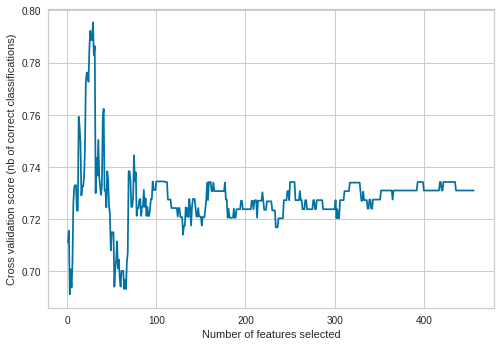

The optimal alpha = 0.07584020486647464
Selected 27 from 456 features.
Accuracy: 0.68


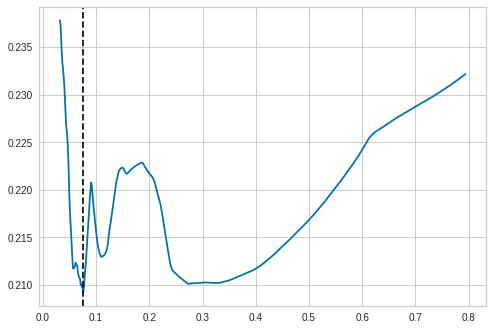

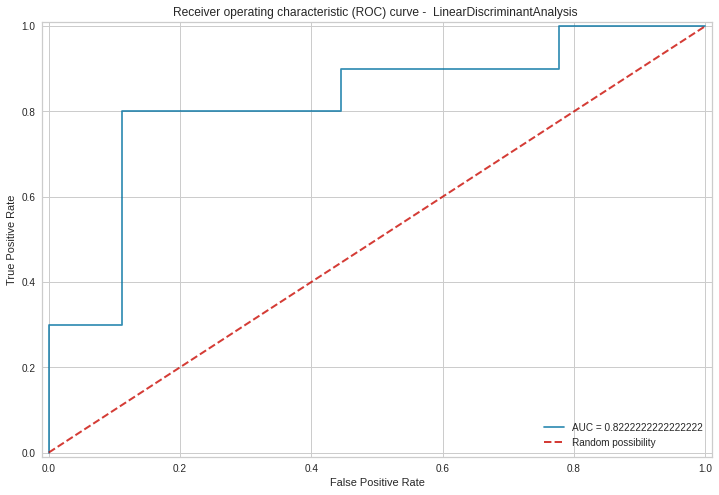

Accuracy: 0.68


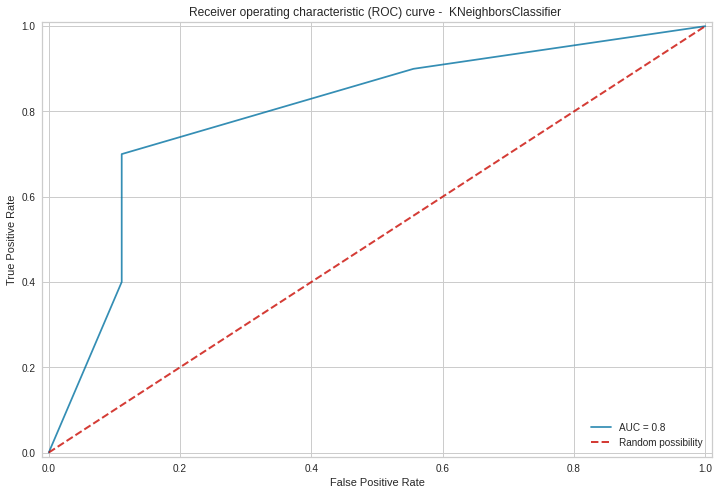

Accuracy: 0.84


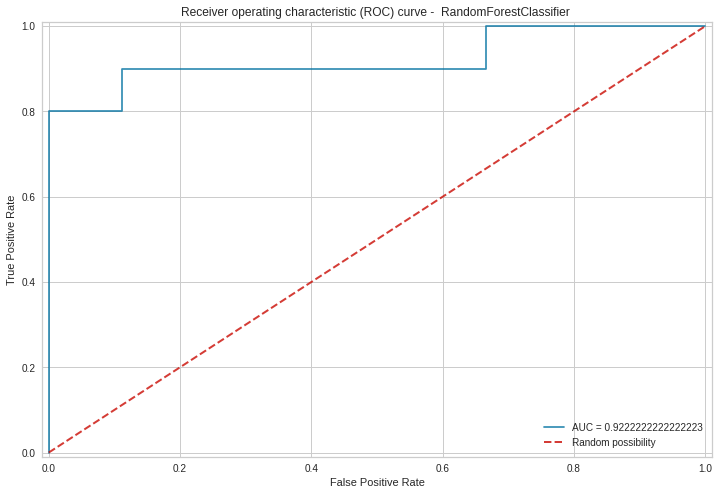

Accuracy: 0.74


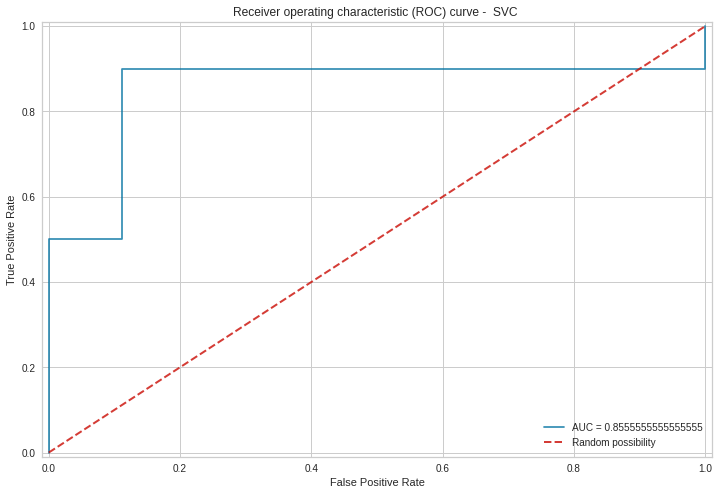

Accuracy: 0.74


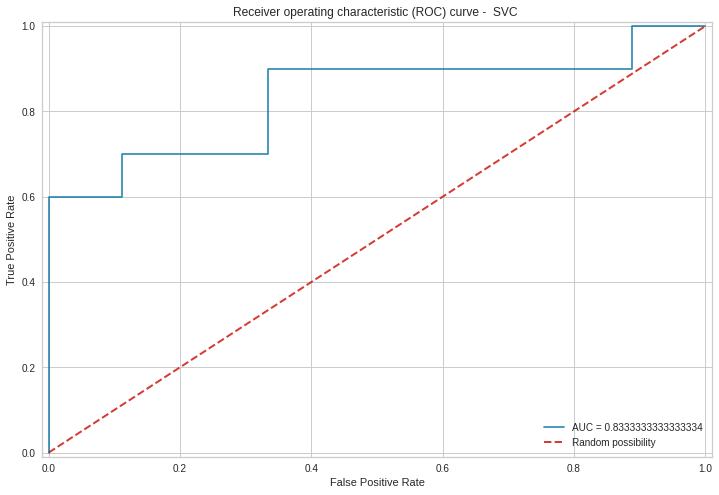

Accuracy: 0.58


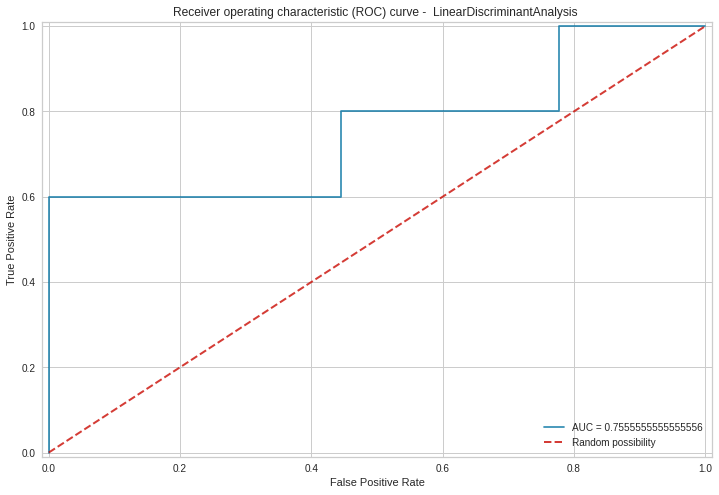

univariate is best for lda
univariate is best for svm
univariate is best for lda
univariate is best for svm


In [23]:
# Transformation of data after feature selection:

# Obtain transformed (feature) dataset after selected features with Univariate analysis:
x_train_uni, x_val_uni = univariate_feature_selection(x_train_prep, y_train, x_val_prep, 10)

# Obtain transformed (feature) dataset after selected features with RFECV
x_train_rfecv, x_val_rfecv = recursive_feature_elimination(svm.SVC(kernel='linear'), x_train_prep, y_train, x_val_prep)

# Obtain transformed (feature) dataset after selected features with LASSO
n_selected, x_train_l1, x_val_l1, alpha_best = lasso_selection(10, x_train_prep, y_train, x_val_prep)

#Create new models with transformed data:

#Univariate analysis:
model_svm_uni = svm.SVC(kernel='linear', probability=True)
model_svm_uni.fit(x_train_uni, y_train)

model_knn_uni = KNeighborsClassifier()
model_knn_uni.fit(x_train_uni, y_train)

model_rf_uni = RandomForestClassifier()
model_rf_uni.fit(x_train_uni, y_train)

model_lda_uni = LDA()
model_lda_uni.fit(x_train_uni, y_train)

#RFECV:
model_svm_rfecv = svm.SVC(kernel='linear', probability=True)
model_svm_rfecv.fit(x_train_rfecv, y_train)

#LASSO:
model_lda_lasso = LDA()
model_lda_lasso.fit(x_train_l1, y_train)

# Accuracy and AUC on validation set:

# Accuracy and AUC on validation set:

# Univariate analysis:
acc_lda_uni, auc_lda_uni = roc_acc(x_val_uni, y_val, model_lda_uni)
acc_knn_uni, auc_knn_uni = roc_acc(x_val_uni, y_val, model_knn_uni) 
acc_rf_uni, auc_rf_uni = roc_acc(x_val_uni, y_val, model_rf_uni) 
acc_svm_uni, auc_svm_uni = roc_acc(x_val_uni, y_val, model_svm_uni)  

# RFECV:
acc_svm_rfecv, auc_svm_rfecv = roc_acc(x_val_rfecv, y_val, model_svm_rfecv)

# LASSO:
acc_lda_lasso, auc_lda_lasso = roc_acc(x_val_l1, y_val, model_lda_lasso)


feature_selected_models = [model_knn_uni, model_rf_uni]
if auc_lda_lasso > auc_lda_uni:
  feature_selected_models.append(model_lda_lasso)
  print('lasso is best for lda')
else: 
  feature_selected_models.append(model_lda_uni)
  print('univariate is best for lda')

if auc_svm_rfecv > auc_svm_uni:
  feature_selected_models.append(model_svm_rfecv)
  print('rfecv is best for svm')
else: 
  feature_selected_models.append(model_svm_uni)
  print('univariate is best for svm')

feature_selected_models = [model_knn_uni, model_rf_uni]
if auc_lda_lasso > auc_lda_uni:
  feature_selected_models.append(model_lda_lasso)
  print('lasso is best for lda')
else: 
  feature_selected_models.append(model_lda_uni)
  print('univariate is best for lda')

if auc_svm_rfecv > auc_svm_uni:
  feature_selected_models.append(model_svm_rfecv)
  print('rfecv is best for svm')
else: 
  feature_selected_models.append(model_svm_uni)
  print('univariate is best for svm')



## Section 5: Model Optimization


* Hyperparameters 

Best hyperparameters knn: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'leaf_size': 21}
Score hyperparameter knn: 0.8455238095238095
Best hyperparameters rf: {'n_estimators': 320, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
Score hyperparameter rf: 0.8693333333333332
Best hyperparameters svm: {'C': 2.5599452033620267, 'gamma': 0.06808361216819946, 'kernel': 'rbf'}
Score hyperparameter svm: 0.8866666666666667
Accuracy: 0.74


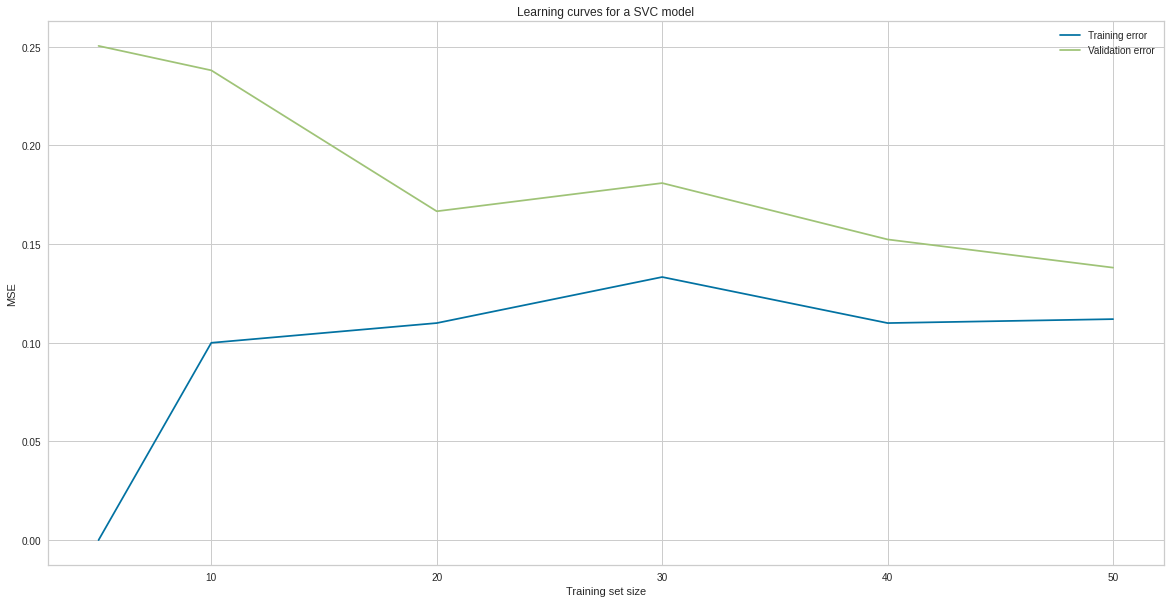

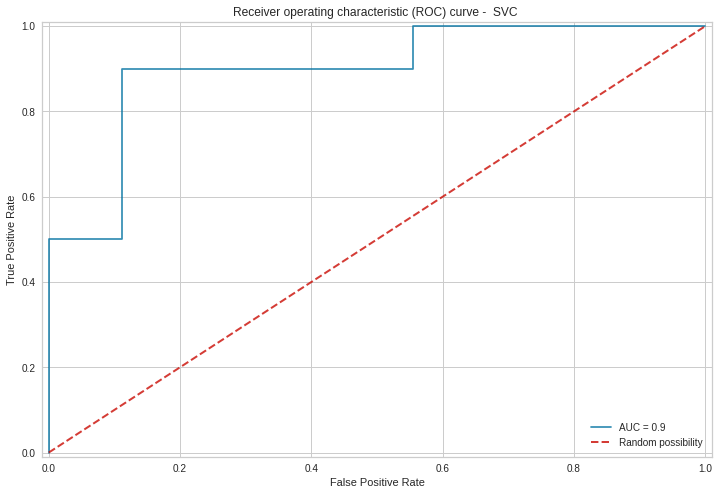

Accuracy: 0.84


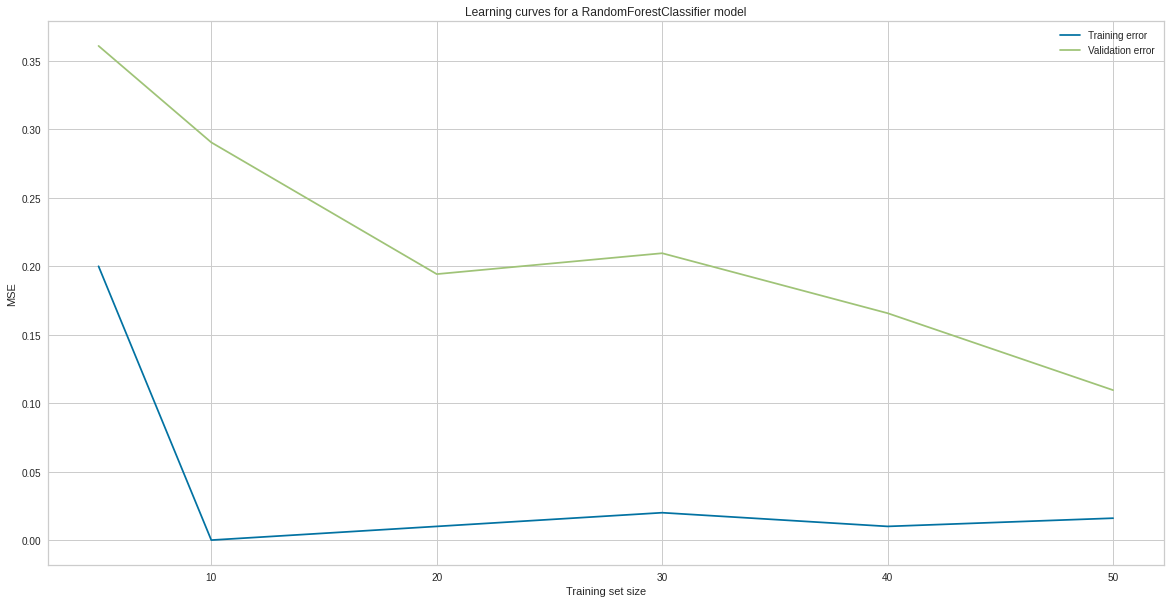

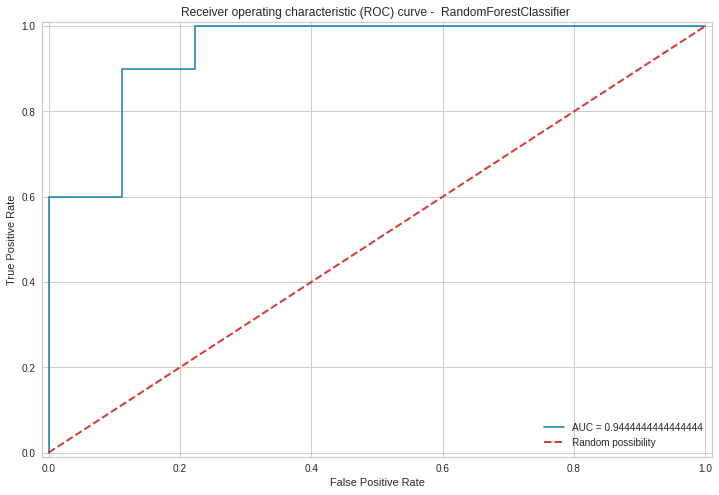

Accuracy: 0.74


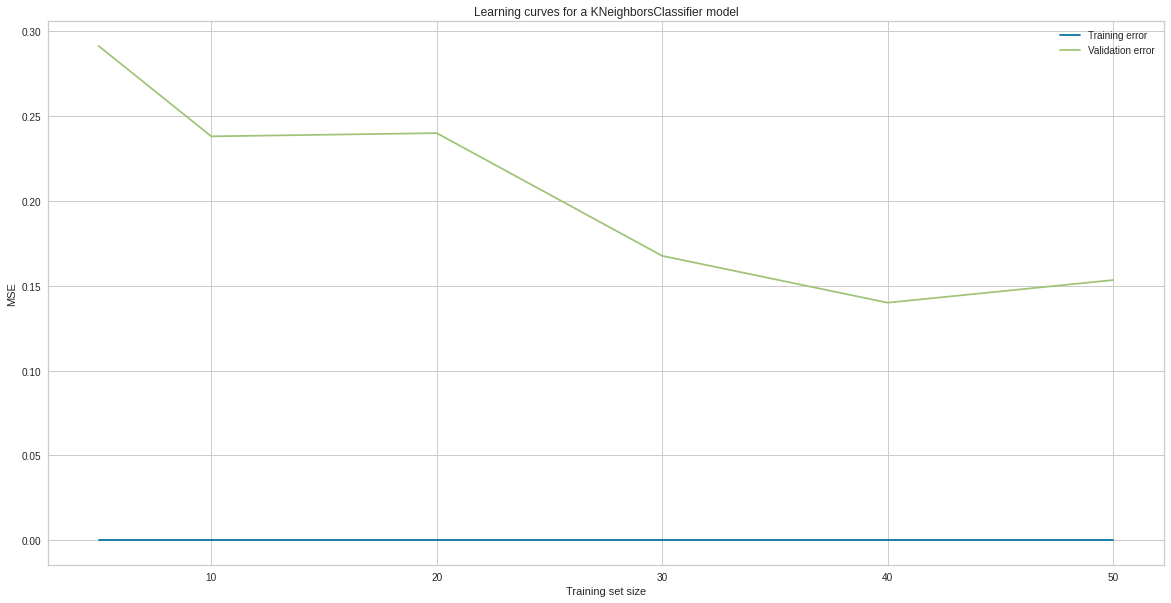

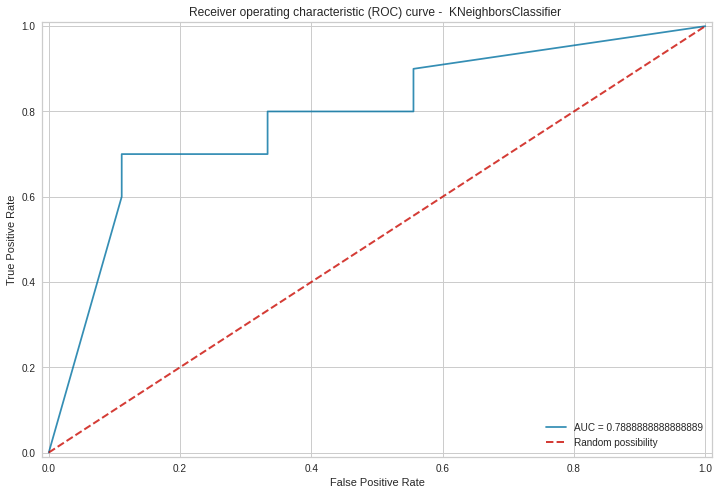

Accuracy: 0.68


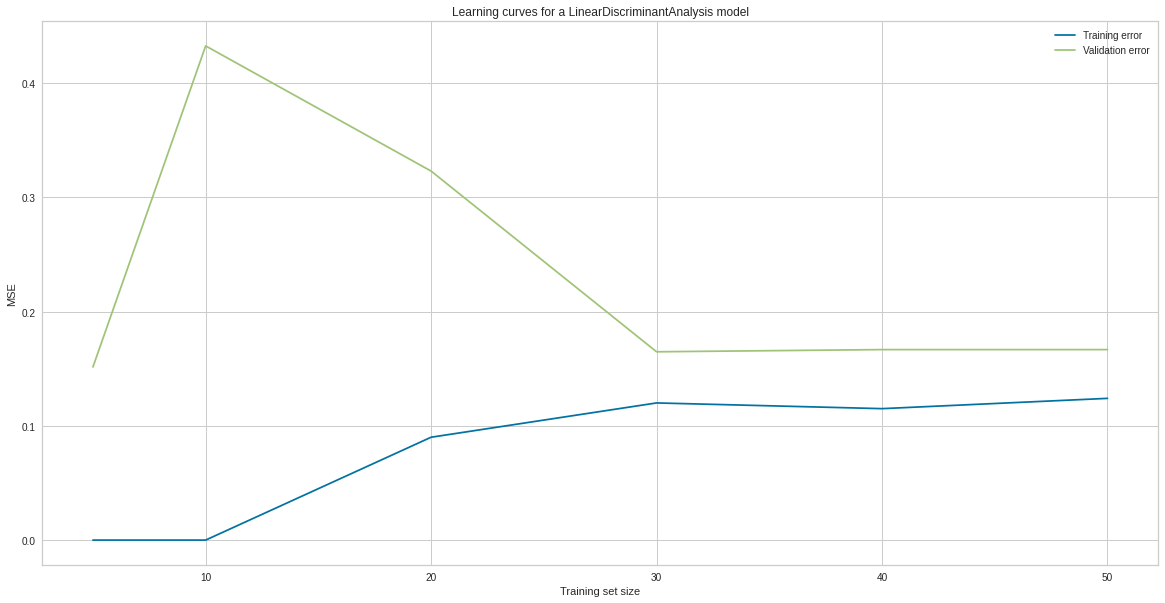

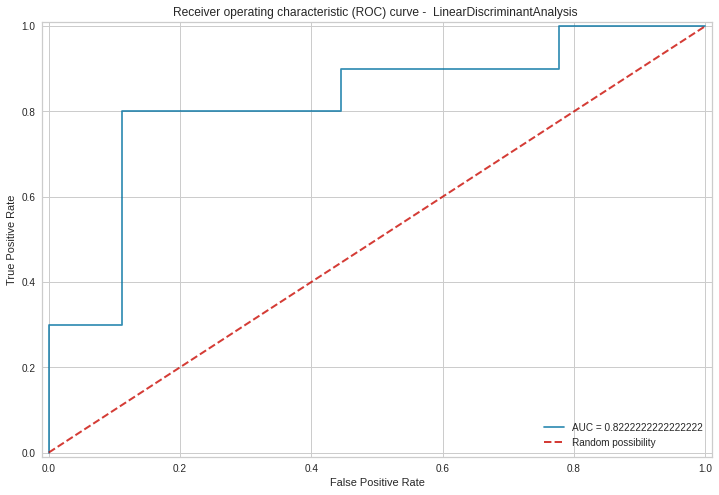

In [36]:

# Hyperparameter training:

#Specifying random grid - hyperparameters:
grid_param_svm_random = {"C": stats.uniform(1, 10), "gamma": stats.uniform(0.01, 1),'kernel': ['rbf', 'poly', 'linear']}
grid_param_rf_random = {'max_depth': list(range(20)), 'min_samples_leaf': list(range(10)), 
                        'min_samples_split': list(range(20)), 'n_estimators': list(range(500)),
                        'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 
                        'max_features': list(range(30))}
grid_param_knn_random = {'n_neighbors': list(range(5)), 'weights':['uniform','distance'], 
                         'leaf_size':list(range(50)), 'p': [1,2]}

#Obtain best parameters:
hyperparameters_knn, score_knn = hyperparameter_training(KNeighborsClassifier(),grid_param_knn_random, x_train_uni, y_train)
print(f'Best hyperparameters knn: {hyperparameters_knn}')
print(f'Score hyperparameter knn: {score_knn}')

hyperparameters_rf, score_rf = hyperparameter_training(RandomForestClassifier(),grid_param_rf_random, x_train_uni, y_train)
print(f'Best hyperparameters rf: {hyperparameters_rf}')
print(f'Score hyperparameter rf: {score_rf}')

hyperparameters_svm, score_svm = hyperparameter_training(svm.SVC(),grid_param_svm_random, x_train_uni, y_train)
print(f'Best hyperparameters svm: {hyperparameters_svm}')
print(f'Score hyperparameter svm: {score_svm}')

# Train new model with found hyperparameters 
model_svm=svm.SVC(**hyperparameters_svm, probability=True)
model_svm.fit(x_train_uni, y_train)

model_rf=RandomForestClassifier(**hyperparameters_rf)
model_rf.fit(x_train_uni, y_train)

# model_linear=Lasso(alpha=alpha_best, random_state = 42)
# model_linear.fit(x_train_uni,y_train)

model_knn=KNeighborsClassifier(**hyperparameters_knn)
model_knn.fit(x_train_uni, y_train)
    
#Learning curves
train_sizes = [5, 10, 20, 30, 40, 50]

for model in [model_svm, model_rf, model_knn, model_lda_uni]:

    learning_curves(model, x_train_uni, y_train, train_sizes, 5)
    roc_acc(x_val_uni, y_val, model)


## Section 5: Model Evaluation and Performance
In this section the different model strategies are evaluated using repeated cross-validation.

These strategies include:
1. SVM with univariate and PCA
2. SVM with RFECV
3. RF with univariate
4. KNN with univeriate
5. Linear moddel (Lasso)
6. LDA with univariate



clf index: 0
Accuracy: 0.87 (+/- 0.11)


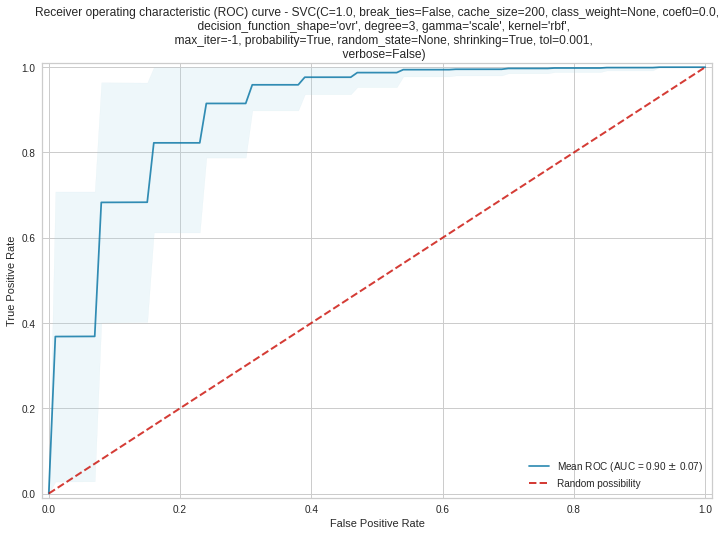

Time to perform repeated cross-validation for SVC (with univariate): 365.21 seconds
clf index: 1


In [0]:
# Clean data
data_cleaned = clean_data(data)

# Split features and labels
labels = data_cleaned['label']
features = data_cleaned.drop(columns=['label'])
features_ar = np.asarray(features)

# Convert labels to binary labels and array
labels = sklearn.preprocessing.label_binarize(labels, ['LGG','GBM'])
labels = [i[0] for i in labels]
labels = np.asarray(labels)
# LGG = 0, GBM = 1

## Repeated Cross-Validation

# List with classifiers
classifiers= [svm.SVC(probability=True),
              svm.SVC(probability=True,  max_iter=5),
              KNeighborsClassifier(),
              RandomForestClassifier(),
              LDA(),
              LDA()]

#Specifying random grid - hyperparameters:
grid_param_svm_random = {"clf__C": stats.uniform(1, 10), "clf__gamma": stats.uniform(0.01, 1),'clf__kernel': ['rbf', 'poly', 'linear']}
grid_param_rf_random = {'clf__max_depth': list(range(1,20)), 'clf__min_samples_leaf': list(range(10)), 
                        'clf__min_samples_split': list(range(1,20)), 'clf__n_estimators': list(range(500)),
                        'clf__bootstrap': [True, False], 'clf__criterion': ['gini', 'entropy'], 
                        'clf__max_features': range(1,10)}
grid_param_knn_random = {'clf__n_neighbors': list(range(6)), 'clf__weights':['uniform','distance'], 
                         'clf__leaf_size':list(range(50)), 'clf__p': [1,2]}
param_grid_LDA = {}


# List with random parameter grids
param_grids = [grid_param_svm_random, grid_param_svm_random, grid_param_knn_random, grid_param_rf_random, param_grid_LDA, param_grid_LDA]

# RepeatedStratifiedKFold (cross-validation)
kf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=9)

# Run for each classifier
for i, (clf, param_grid) in enumerate(zip(classifiers, param_grids)):
  
  print(f'clf index: {i}')
  
  # Create empty lists for results
  tprs = []
  aucs = []
  accuracy = []
  models = []

  start = time.time()

  for num, (train, test) in enumerate(kf.split(features, labels)):
    # train is the train set and val the validation set

    # Create x_train and y_train using train and test index
    x_train, y_train = features_ar[train], labels[train]
    x_test, y_test = features_ar[test], labels[test]
  
    # SVC/RF/k-NN with Univeriate
    if i == 0 or i == 2 or i == 3:
      steps = [('imputation', KNNImputer(n_neighbors=5, weights='distance')),
               ('scaler', sklearn.preprocessing.RobustScaler()),
               ('Univariate', SelectKBest()),
               ('clf', clf)]
      pipe = Pipeline(steps)
      model = RandomizedSearchCV(pipe, param_grid, n_iter=10, scoring='accuracy', n_jobs=-1)
      # Fit model on train data
      model.fit(x_train, y_train)
      name = '' + str(clf).split('(')[0] + ' (with univariate)'

    # SVC with RFECV
    if i == 1:
      steps = [('imputation', KNNImputer(n_neighbors=5, weights='distance')),
               ('scaler', sklearn.preprocessing.RobustScaler()),
               ('RFECV', RFECV(svm.SVC(kernel='linear'), step=1, cv=5,scoring='roc_auc', n_jobs=-1)),
               ('clf', clf)]
      pipe = Pipeline(steps)
      model = RandomizedSearchCV(pipe, param_grid, n_iter=10, scoring='accuracy', n_jobs=-1)
      # Fit model on train data
      model.fit(x_train, y_train)
      name = 'SVC (with RFECV)'

    # LDA with Lasso
    if i == 4:
      # Impute and scale data
      x_train_prep, x_test_prep = data_impute_scale(x_train, x_test)
      # Lasso
      data_train_l1, data_test_l1 = lasso_selection_cv(10, x_train_prep, y_train, x_test_prep)
      # Fit LDA model
      model = clf.fit(data_train_l1,y_train)
      # Fit model on  train data
      name = 'LDA with Lasso'

    # LDA with univariate
    if i == 5:
      steps = [('imputation', KNNImputer(n_neighbors=5, weights='distance')),
               ('scaler', sklearn.preprocessing.RobustScaler()),
               ('Univariate', SelectKBest()),
               ('clf', clf)]
      pipe = Pipeline(steps)
      # Fit pipeline on train data
      model = pipe.fit(x_train, y_train)
      # Fit model on train data
      model.fit(x_train, y_train)
      name = '' + str(clf).split('(')[0] + ' (with univariate)'

    if i == 4:
      # Compute results
      tprs, aucs, accuracy = results(model, data_test_l1, y_test, tprs, aucs, accuracy)
    else:
      tprs, aucs, accuracy = results(model, x_test, y_test, tprs, aucs, accuracy)
  
  results_acc_roc(tprs, aucs, accuracy, clf)

  end = time.time()
  seconds =  round((end - start), 2)
  print(f'Time to perform repeated cross-validation for {name}: {seconds} seconds')

print('Complete')
